Mounting the google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Defining the dataset path

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/info/data"

Data Augmentation and preprocessing

In [ ]:
data_generator = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

#Loading training data
train_generator = data_generator.flow_from_directory(
    directory=data_dir + "/train",
    target_size=(28, 28),
    batch_size=32,
    class_mode="sparse",
)

#Load validation data
validation_generator = data_generator.flow_from_directory(
    directory=data_dir + "/val",
    target_size=(28, 28),
    batch_size=32,
    class_mode="sparse",
    shuffle=False  #Ensure labels align with predictions
)
print(train_generator.class_indices)

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.
{'class_0': 0, 'class_1': 1, 'class_2': 2, 'class_3': 3, 'class_4': 4, 'class_5': 5, 'class_6': 6, 'class_7': 7, 'class_8': 8, 'class_9': 9, 'class_A': 10, 'class_B': 11, 'class_C': 12, 'class_D': 13, 'class_E': 14, 'class_F': 15, 'class_G': 16, 'class_H': 17, 'class_I': 18, 'class_J': 19, 'class_K': 20, 'class_L': 21, 'class_M': 22, 'class_N': 23, 'class_O': 24, 'class_P': 25, 'class_Q': 26, 'class_R': 27, 'class_S': 28, 'class_T': 29, 'class_U': 30, 'class_V': 31, 'class_W': 32, 'class_X': 33, 'class_Y': 34, 'class_Z': 35}


Mapping Alphabets

In [ ]:
#Get class index mapping
class_indices = validation_generator.class_indices

#Reverse the dictionary (this will get label index → character)
index_to_class = {v: k for k, v in class_indices.items()}

#Convert from folder names (class_A, class_B) to actual characters ('A', 'B')
index_to_char = {i: k.split("_")[-1] for i, k in index_to_class.items()}  #Extract last part after '_'

#Print the mapping
print(index_to_char)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z'}


Custom F1 Score Metric

In [ ]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="tp", initializer="zeros")
        self.false_positives = self.add_weight(name="fp", initializer="zeros")
        self.false_negatives = self.add_weight(name="fn", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=1)
        y_true = tf.cast(y_true, tf.int64)

        tp = tf.reduce_sum(tf.cast(tf.equal(y_pred, y_true), tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.not_equal(y_pred, y_true), tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.not_equal(y_true, y_pred), tf.float32))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

Model Architecture

In [ ]:
K.clear_session()
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(36, activation='softmax')
])

#Compile Model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy', F1Score()]
)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 7, 7, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │           9,252 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 397,668 (1.52 MB)

 Trainable params: 397,668 (1.52 MB)

 Non-trainable params: 0 (0.00 B)

Custom Callback

In [ ]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs and logs.get("val_f1_score") > 0.99:
            print("\n Reached 99% Validation F1 Score, stopping training!!")
            self.model.stop_training = True

callbacks = [
    EarlyStoppingCallback(),
    tf.keras.callbacks.ModelCheckpoint('char_recog1.keras', save_best_only=True, monitor='val_f1_score', mode='max'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7)
]

Model training

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 227s 8s/step - accuracy: 0.0598 - f1_score: 0.0598 - loss: 3.5396 - val_accuracy: 0.2604 - val_f1_score: 0.2604 - val_loss: 2.9508 - learning_rate: 0.0010
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 305ms/step - accuracy: 0.2348 - f1_score: 0.2348 - loss: 2.7404 - val_accuracy: 0.6719 - val_f1_score: 0.6719 - val_loss: 1.4898 - learning_rate: 0.0010
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.4879 - f1_score: 0.4879 - loss: 1.5894 - val_accuracy: 0.7917 - val_f1_score: 0.7917 - val_loss: 0.8573 - learning_rate: 0.0010
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.6467 - f1_score: 0.6467 - loss: 1.1358 - val_accuracy: 0.8438 - val_f1_score: 0.8437 - val_loss: 0.5062 - learning_rate: 0.0010
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 233ms/step - accuracy: 0.7481 - f1_score: 0.7481 - loss: 0.7622 - val_accuracy: 0.9010 - val_f1_score: 0.9010 - val_loss: 0.3138 - learning_rate: 0.0010
Epoch 6/25
27/27 ━━━━━━━━━━━━

Model Evaluation

In [ ]:
from sklearn.metrics import classification_report

#Load the best model
best_model = tf.keras.models.load_model('char_recog1.keras', custom_objects={'F1Score': F1Score})

#Predict on validation data
Y_true = validation_generator.classes
Y_pred = best_model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

#Generate Classification Report
print("Validation Classification Report:")
print(classification_report(Y_true, Y_pred_classes, target_names=list(validation_generator.class_indices.keys())))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
Validation Classification Report:
              precision    recall  f1-score   support

     class_0       1.00      0.67      0.80         6
     class_1       1.00      1.00      1.00         6
     class_2       1.00      1.00      1.00         6
     class_3       1.00      1.00      1.00         6
     class_4       0.86      1.00      0.92         6
     class_5       1.00      1.00      1.00         6
     class_6       1.00      1.00      1.00         6
     class_7       1.00      1.00      1.00         6
     class_8       1.00      0.83      0.91         6
     class_9       1.00      1.00      1.00         6
     class_A       1.00      0.83      0.91         6
     class_B       0.86      1.00      0.92         6
     class_C       1.00      1.00      1.00         6
     class_D       1.00      1.00      1.00         6
     class_E       1.00      1.00      1.00         6
     class_F       1.00      1.00      1.00         6
     cla

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step


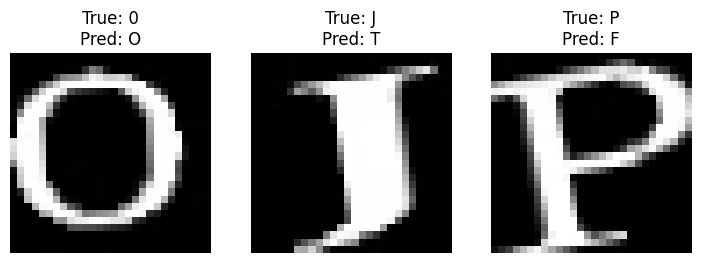

In [ ]:
#Reset the validation generator to ensure consistent ordering
validation_generator.reset()

#Generate predictions for the validation set
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(y_pred, axis=1)  #Convert predictions to class indices

#Extract true labels from the validation generator
y_true = validation_generator.classes

#Find misclassified samples
misclassified_indices = np.where(y_pred != y_true)[0]

#Display some misclassified images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(misclassified_indices[:10]):  #Shows first 10 misclassified images
    plt.subplot(2, 5, i + 1)
    img = validation_generator[idx // validation_generator.batch_size][0][idx % validation_generator.batch_size]
    plt.imshow(img)
    plt.title(f'True: {index_to_char[y_true[idx]]}\nPred: {index_to_char[y_pred[idx]]}')
    plt.axis('off')
plt.show()

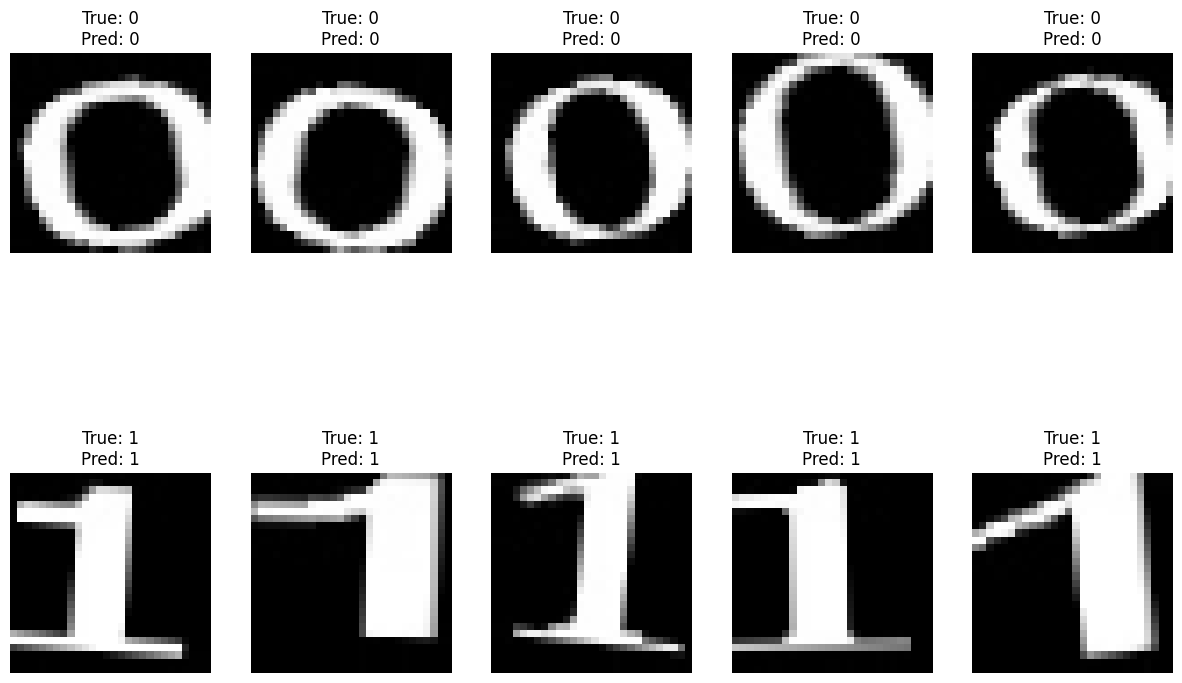

In [ ]:
#Find correctly predicted samples
correctly_predicted_indices = np.where(y_pred == y_true)[0]

#Display some correctly predicted images
plt.figure(figsize=(15, 10))
for i, idx in enumerate(correctly_predicted_indices[:10]):  #first 10 correctly predicted images
    plt.subplot(2, 5, i + 1)
    img = validation_generator[idx // validation_generator.batch_size][0][idx % validation_generator.batch_size]
    plt.imshow(img)
    plt.title(f'True: {index_to_char[y_true[idx]]}\nPred: {index_to_char[y_pred[idx]]}')
    plt.axis('off')
plt.show()

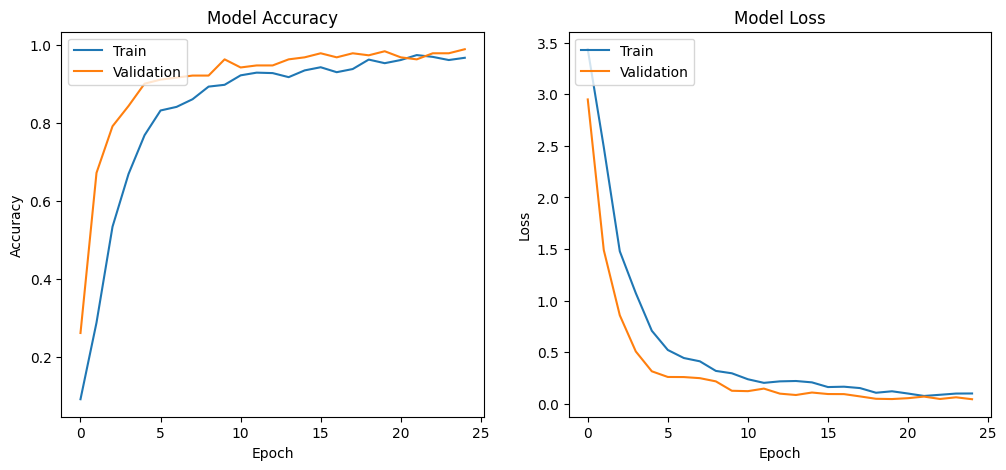

In [ ]:
#Plot learning curves
plt.figure(figsize=(12, 5))

#Plot training vs validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

#Plot training vs validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 268ms/step


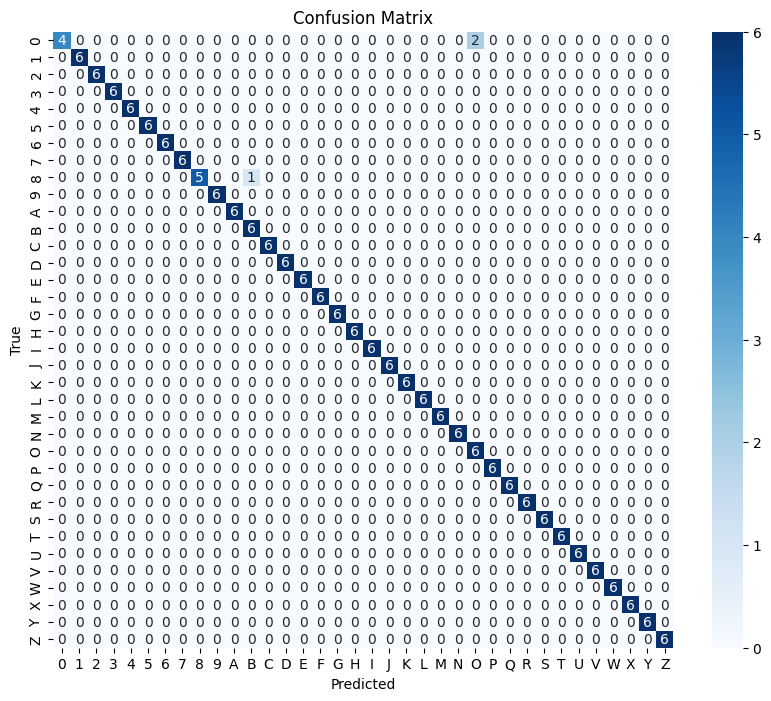

In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

validation_generator.reset()

#Generate predictions for the validation set
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred = np.argmax(y_pred, axis=1)

#Extract true labels
y_true = validation_generator.classes

#Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

#Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=index_to_char.values(), yticklabels=index_to_char.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save('/content/drive/MyDrive/char_recog1.keras')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
